In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

PATHNAME = "./data/"
P_VALUE = 0.05

In [2]:
meat_production_df = pd.read_csv(PATHNAME+"Meat_Stats_Meat_Production.csv").dropna()
meat_slaughter_df = pd.read_csv(PATHNAME+"Meat_Stats_Slaughter_Counts.csv").dropna()
meat_weights_df = pd.read_csv(PATHNAME+"Meat_Stats_Slaughter_Weights.csv").dropna()
sugar_coffee_df = pd.read_csv(PATHNAME+"all_commodities.csv")
unemployment_df = pd.read_csv(PATHNAME+"acs_5yr_est_selected_economic_characteristics_2010-2022.csv")

In [3]:
unemployment_df = unemployment_df.replace('(X)', np.nan)

unemployment_df['Estimate'] = unemployment_df['Estimate'].astype(str).str.replace(',', '').astype(float)
unemployment_df['Label (Grouping)'] = unemployment_df['Label (Grouping)'].str.lstrip()
unemployment_df['Estimate']

0              NaN
1        3714504.0
2        2246848.0
3        2230879.0
4        2036867.0
           ...    
98015          NaN
98016          NaN
98017          NaN
98018          NaN
98019          NaN
Name: Estimate, Length: 98020, dtype: float64

In [4]:
Midwest = ['Illinois', 'Indiana', 'Iowa', 'Kansas', 'Michigan', 'Minnesota', 'Missouri', 'Nebraska', 'North Dakota', 'Ohio', 'South Dakota', 'Wisconsin']
South = ['Delaware', 'Florida', 'Georgia', 'Maryland', 'North Carolina', 'South Carolina', 'Virginia', 'Washington D.C.', 'West Virginia', 'Alabama', 'Kentucky', 'Mississippi', 'Tennessee', 'Arkansas', 'Louisiana', 'Oklahoma', 'Texas']
West = ['Arizona', 'Colorado', 'Idaho', 'Montana', 'Nevada', 'New Mexico', 'Utah', 'Wyoming', 'Alaska', 'California', 'Hawaii', 'Oregon', 'Washington']
East = ['Connecticut', 'Maine', 'Massachusetts', 'New Hampshire', 'Rhode Island', 'Vermont', 'New Jersey', 'New York', 'Pennsylvania']

In [5]:
# Create sub-dataframes for each region and analyze them
regions = {
    'Midwest': Midwest,
    'South': South,
    'West': West,
    'East': East
}

all_regions_df = pd.DataFrame()

for region_name, states in regions.items():
    # Create sub-dataframe for the region
    region_df = unemployment_df[unemployment_df['State'].isin(states)]
    
    # Filter for median household income and Population 16 years and over in labor force
    region_df = region_df[
        ((region_df['Label (Grouping)'].str.contains('Percent Unemployed')) & (region_df['Category'] == 'EMPLOYMENT STATUS')) |
        ((region_df['Label (Grouping)'].str.contains('Unemployment Rate')) & (region_df['Category'] == 'EMPLOYMENT STATUS')) |
        ((region_df['Label (Grouping)'] == 'Median household income (dollars)')) |
        ((region_df['Label (Grouping)'].str.contains('All people')) & (region_df['Category'] == 'PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL'))
    ]
    region_df['Percent'] = region_df['Percent'].str.rstrip('%').astype('float')

    # Split region_df into three different dataframes
    unemployed_df = region_df[region_df['Label (Grouping)'].str.contains('Percent Unemployed') | region_df['Label (Grouping)'].str.contains('Unemployment Rate')]
    income_df = region_df[region_df['Label (Grouping)'] == 'Median household income (dollars)']
    poverty_df = region_df[region_df['Label (Grouping)'].str.contains('All people')]

    # Rename columns for clarity
    unemployed_df = unemployed_df.rename(columns={'Percent': 'Unemployment Rate'})
    income_df = income_df.rename(columns={'Estimate': 'Median Household Income'})
    poverty_df = poverty_df.rename(columns={'Percent': 'Poverty Rate'})

    # Reassign region_df to include all three dataframes
    region_df = pd.concat([unemployed_df, income_df, poverty_df])
    
    # Add Region column
    region_df['Region'] = region_name
    
    # Append to all_regions_df
    all_regions_df = pd.concat([all_regions_df, region_df], ignore_index=True)


all_regions_df.drop(['Percent', 'Estimate'], axis=1, inplace=True)
unemployment_regions_df = all_regions_df[all_regions_df["Category"] == "EMPLOYMENT STATUS"]
income_regions_df = all_regions_df[all_regions_df["Category"].str.startswith("EMPLOYMENT STATUS")]
poverty_regions_df = all_regions_df[all_regions_df["Category"] == "PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL"]

In [6]:
unemployment_regions_df

,Label (Grouping),Category,State,Margin of Error,Unemployment Rate,Percent Margin of Error,Year,Median Household Income,Poverty Rate,Region
0,Percent Unemployed,EMPLOYMENT STATUS,Illinois,NaN,8.6,±0.1,2010,NaN,NaN,Midwest
1,Percent Unemployed,EMPLOYMENT STATUS,Indiana,NaN,8.4,±0.1,2010,NaN,NaN,Midwest
2,Percent Unemployed,EMPLOYMENT STATUS,Iowa,NaN,5.3,±0.1,2010,NaN,NaN,Midwest
3,Percent Unemployed,EMPLOYMENT STATUS,Kansas,NaN,6.0,±0.1,2010,NaN,NaN,Midwest
4,Percent Unemployed,EMPLOYMENT STATUS,Michigan,NaN,11.5,±0.1,2010,NaN,NaN,Midwest
...,...,...,...,...,...,...,...,...,...,...
1711,Unemployment Rate,EMPLOYMENT STATUS,New Jersey,NaN,6.2,±0.1,2021,NaN,NaN,East
1712,Unemployment Rate,EMPLOYMENT STATUS,New York,NaN,6.2,±0.1,2021,NaN,NaN,East
1713,Unemployment Rate,EMPLOYMENT STATUS,Pennsylvania,NaN,5.5,±0.1,2021,NaN,NaN,East
1714,Unemployment Rate,EMPLOYMENT STATUS,Rhode Island,NaN,6.0,±0.3,2021,NaN,NaN,East


# Meat Production

In [7]:
meat_production_df['Production'] = pd.to_numeric(meat_production_df['Production'], errors='coerce')
agg_meat_df = meat_production_df.groupby(['Year', "Type of Meat"])['Production'].sum().reset_index()
merged_unemployment_meat_df = pd.merge(unemployment_regions_df[["Year", "Region", "Unemployment Rate"]], agg_meat_df, on=['Year'], how='inner')
merged_unemployment_meat_df = merged_unemployment_meat_df.dropna(subset=['Unemployment Rate', 'Production'])

merged_poverty_meat_df = pd.merge(poverty_regions_df[["Year", "Region", "Poverty Rate"]], agg_meat_df, on=['Year'], how='inner')
merged_poverty_meat_df = merged_poverty_meat_df.dropna(subset=['Poverty Rate', 'Production'])

In [8]:
merged_unemployment_red_meat_df = merged_unemployment_meat_df[merged_unemployment_meat_df["Type of Meat"] == "Red Meat"].dropna(subset=['Unemployment Rate', 'Production'])
merged_unemployment_poultry_df = merged_unemployment_meat_df[merged_unemployment_meat_df["Type of Meat"] == "Poultry"].dropna(subset=['Unemployment Rate', 'Production'])

In [9]:
merged_poverty_red_meat_df = merged_poverty_meat_df[merged_poverty_meat_df["Type of Meat"] == "Red Meat"].dropna(subset=['Poverty Rate', 'Production'])
merged_poverty_poultry_df = merged_poverty_meat_df[merged_poverty_meat_df["Type of Meat"] == "Poultry"].dropna(subset=['Poverty Rate', 'Production'])

## CCF

In [10]:
def cross_correlation(ts1, ts2, lag):
    fft_values1 = np.fft.fft(ts1)
    frequencies1 = np.fft.fftfreq(len(ts1))
    fft_values1[np.abs(frequencies1) > 0.15] = 0
    ts1 = pd.Series(np.fft.ifft(fft_values1))

    fft_values2 = np.fft.fft(ts2)
    frequencies2 = np.fft.fftfreq(len(ts2))
    fft_values2[np.abs(frequencies2) > 0.1] = 0
    ts2 = pd.Series(np.fft.ifft(fft_values2))
    
    ts1 = np.log(ts1)
    ts2 = np.log(ts2)

    ts1 = ts1.diff()
    ts1 = ts1 / ts1.abs().max() 
    ts1 = ts1.dropna()
    ts2 = ts2.diff()
    ts2 = ts2 / ts2.abs().max() 
    ts2 = ts2.dropna()

    if lag < 0:
        ts1 = ts1[-lag:]
        ts2 = ts2[:lag]
    elif lag > 0:
        ts1 = ts1[:-lag]
        ts2 = ts2[lag:]
    else:
        ts1 = ts1
        ts2 = ts2

    correlation = np.corrcoef(ts1, ts2)[0, 1]
    return correlation

### Red Meat

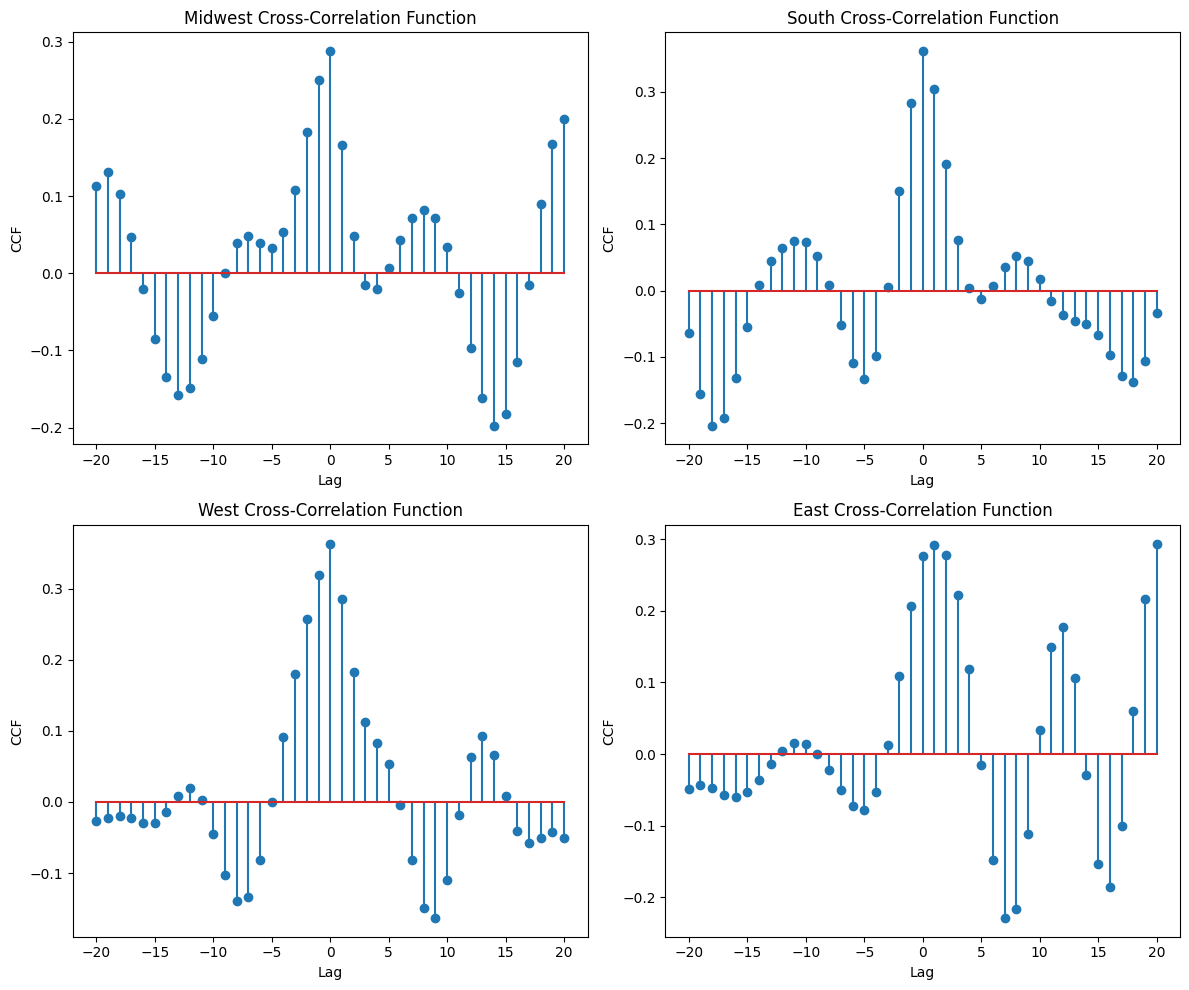

In [11]:
max_lag = 20
fig, axs = plt.subplots(2, 2, figsize = (12, 10))
for i, (region, states) in enumerate(regions.items()):
    lags = np.arange(-max_lag, max_lag + 1)
    unemployment_data = merged_unemployment_red_meat_df[merged_unemployment_red_meat_df["Region"] == region]
    ccf_values = [cross_correlation(unemployment_data["Unemployment Rate"], unemployment_data["Production"], lag) for lag in lags]

    ax = axs[0 if i <= 1 else 1, i%2]
    ax.stem(lags, ccf_values)
    ax.set_title(region +' Cross-Correlation Function')
    ax.set_xlabel('Lag')
    ax.set_ylabel('CCF')

fig.tight_layout()
plt.show()

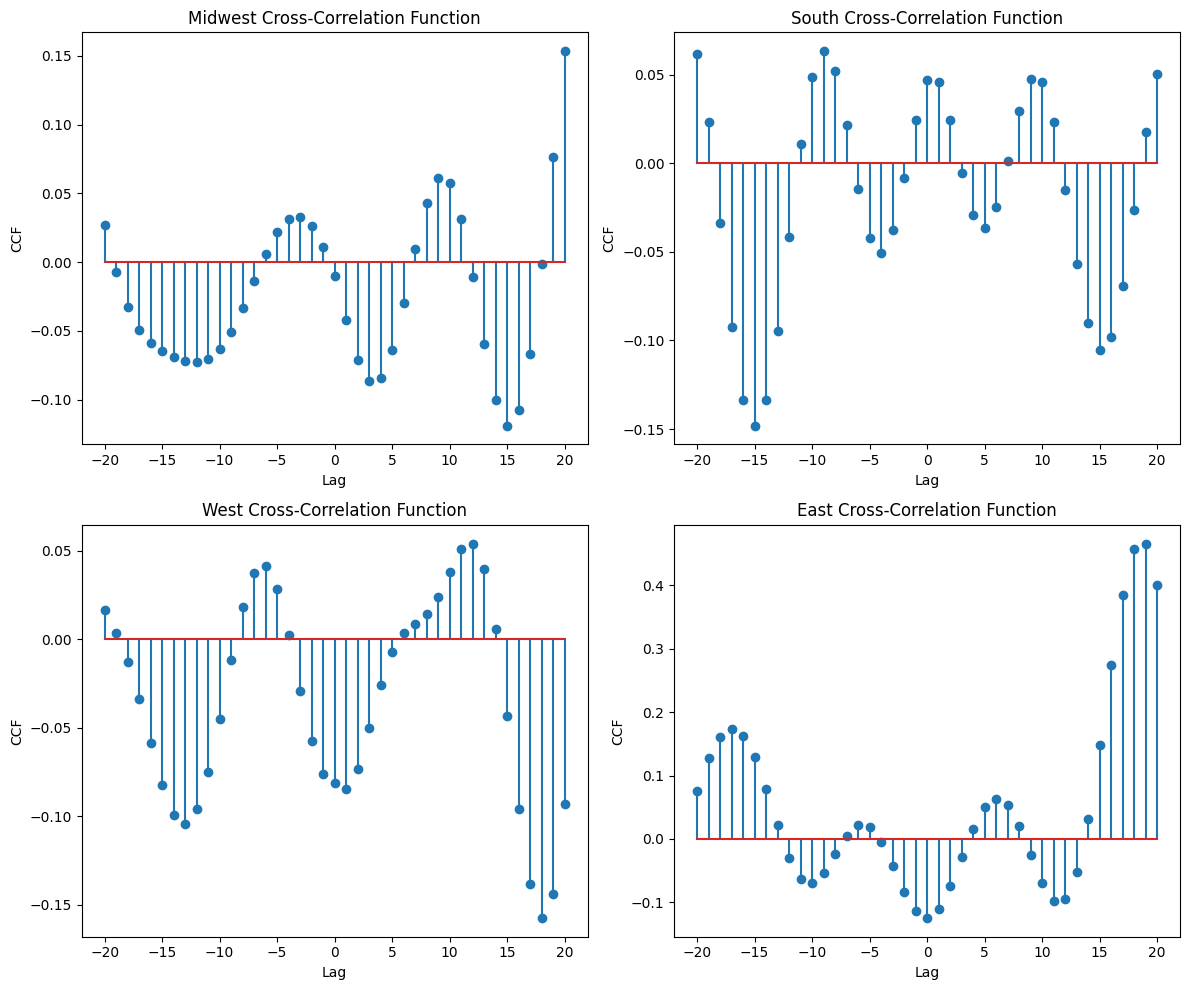

In [12]:
max_lag = 20
fig, axs = plt.subplots(2, 2, figsize = (12, 10))
for i, (region, states) in enumerate(regions.items()):
    lags = np.arange(-max_lag, max_lag + 1)
    unemployment_data = merged_unemployment_poultry_df[merged_unemployment_poultry_df["Region"] == region]
    ccf_values = [cross_correlation(unemployment_data["Unemployment Rate"], unemployment_data["Production"], lag) for lag in lags]

    ax = axs[0 if i <= 1 else 1, i%2]
    ax.stem(lags, ccf_values)
    ax.set_title(region +' Cross-Correlation Function')
    ax.set_xlabel('Lag')
    ax.set_ylabel('CCF')

fig.tight_layout()
plt.show()

# Coffee and Sugar

In [13]:
sugar_coffee_df['Date-Time'] = pd.to_datetime(sugar_coffee_df['Date-Time'])
sugar_coffee_df['Year'] = sugar_coffee_df['Date-Time'].dt.year
sugar_coffee_df['Month'] = sugar_coffee_df['Date-Time'].dt.month
coffee_df = sugar_coffee_df[sugar_coffee_df['Commodity'] == "Coffee"]

Fitted parameters: a=46.28451795976381, b=0.0011466331350461147, c=-0.9470732485089894, d=0.010588231797071308, e=73.07414096625699
Mean Square Error: 1008.2996576854912


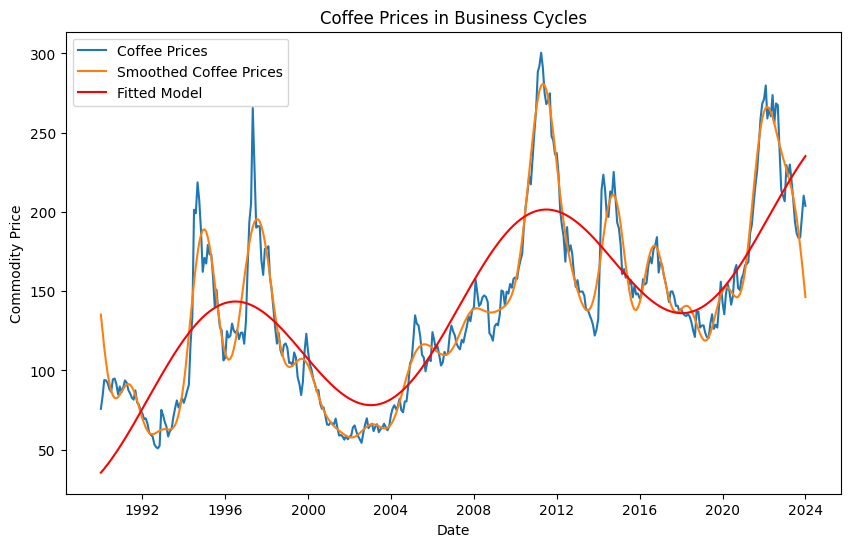

In [89]:
from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error

coffee_df['t'] = (coffee_df['Date-Time'] - coffee_df['Date-Time'].min()).dt.days
plt.figure(figsize=(10, 6))
plt.plot(coffee_df['Date-Time'], coffee_df['Value'], label='Coffee Prices')

sugar_coffee_fft_values = np.fft.fft(coffee_df['Value'])
sugar_coffee_frequencies = np.fft.fftfreq(len(coffee_df['Value']))
sugar_coffee_fft_values[np.abs(sugar_coffee_frequencies) > 0.05] = 0
smoothed_coffee_value = pd.Series(np.fft.ifft(sugar_coffee_fft_values).real)

def business_cycle_model(t, a, b, c, d, e):
    return a * np.sin(b * t + c) + d * t + e

initial_guess = [100, 0.001, 0, 1, 50]
params, covariance = curve_fit(business_cycle_model, coffee_df['t'], smoothed_coffee_value, p0=initial_guess, maxfev = 100000)
a, b, c, d, e = params
print(f"Fitted parameters: a={a}, b={b}, c={c}, d={d}, e={e}")

mse = mean_squared_error(business_cycle_model(coffee_df['t'], *params), smoothed_coffee_value)
print(f"Mean Square Error: {mse}")

plt.plot(coffee_df['Date-Time'], smoothed_coffee_value, label='Smoothed Coffee Prices')
plt.plot(coffee_df['Date-Time'], business_cycle_model(coffee_df['t'], *params), color='red', label='Fitted Model')
plt.xlabel('Date')
plt.ylabel('Commodity Price')
plt.legend()
plt.title('Coffee Prices in Business Cycles')
plt.show()


## CCF

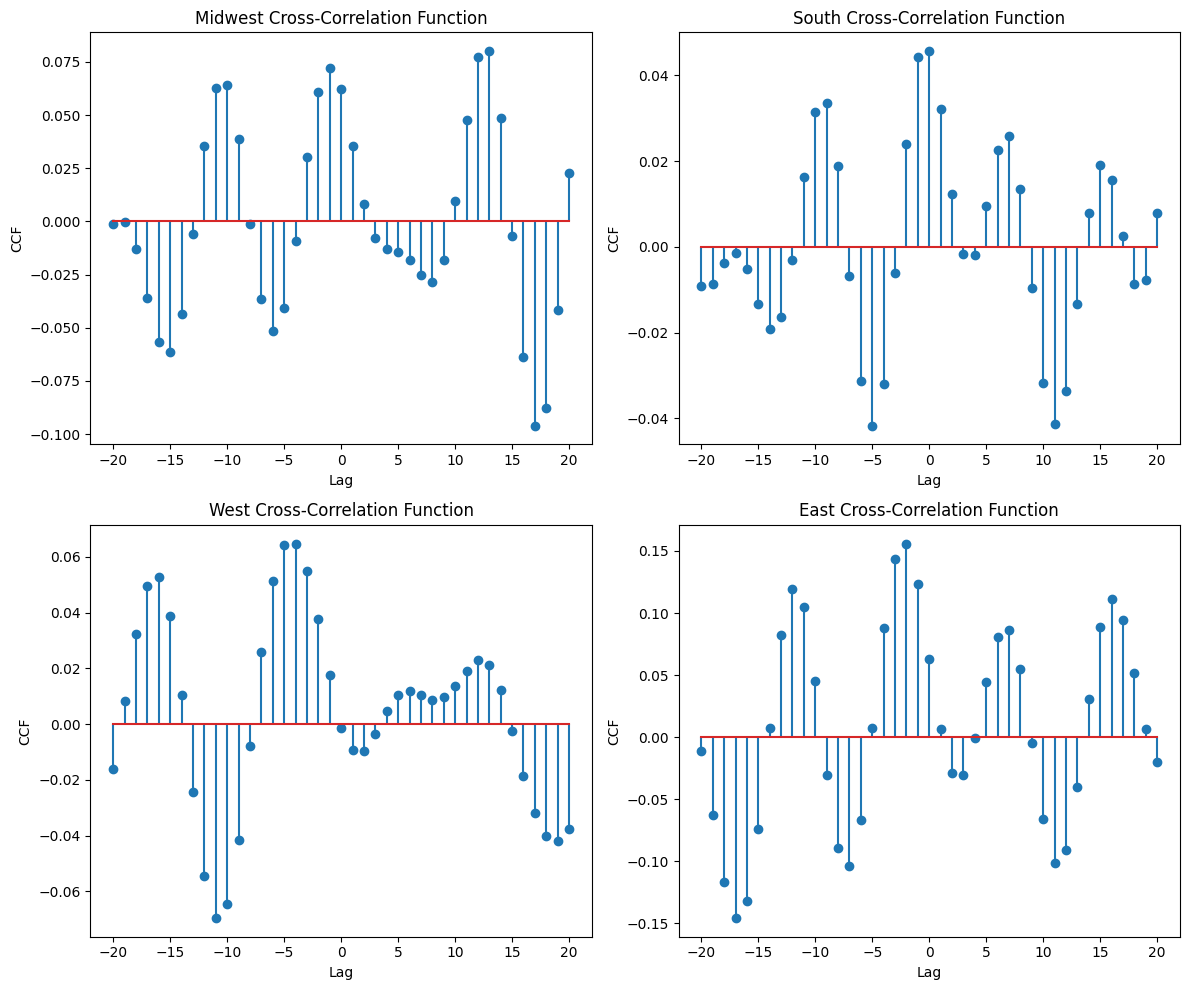

In [17]:
max_lag = 20
fig, axs = plt.subplots(2, 2, figsize = (12, 10))
for i, (region, states) in enumerate(regions.items()):
    lags = np.arange(-max_lag, max_lag + 1)
    unemployment_data = merged_unemployment_sugar_coffee_df[merged_unemployment_sugar_coffee_df["Region"] == region]
    ccf_values = [cross_correlation(unemployment_data["Unemployment Rate"], unemployment_data["Value"], lag) for lag in lags]

    ax = axs[0 if i <= 1 else 1, i%2]
    ax.stem(lags, ccf_values)
    ax.set_title(region +' Cross-Correlation Function')
    ax.set_xlabel('Lag')
    ax.set_ylabel('CCF')

fig.tight_layout()
plt.show()